In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import lite
import tensorflow as tf


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Access Google Drive Folder
import os
COLAB_PATH = "gdrive/MyDrive"
os.chdir(COLAB_PATH)

# Get The dataset

In [4]:
# https://drive.google.com/file/d/1I2NP0BPMbwN0Ad7ikgTvvCzAYeMZF8c2/view?usp=sharing
!gdown https://drive.google.com/uc?id=1I2NP0BPMbwN0Ad7ikgTvvCzAYeMZF8c2 -O animal-behavior-analysis.zip
!unzip -o animal-behavior-analysis.zip

Downloading...
From: https://drive.google.com/uc?id=1I2NP0BPMbwN0Ad7ikgTvvCzAYeMZF8c2
To: /content/gdrive/MyDrive/animal-behavior-analysis.zip
100% 476M/476M [00:03<00:00, 139MB/s]
Archive:  animal-behavior-analysis.zip
  inflating: DogInfo.xlsx            
  inflating: DogMoveData_csv_format/DogMoveData.csv  


In [5]:
DATA_BASE_DIR = "/content/gdrive/MyDrive"

In [6]:
import os
df_dogmov = pd.read_csv(os.path.join(DATA_BASE_DIR,'DogMoveData_csv_format','DogMoveData.csv') )
df_dogmov.head(5)

,DogID,TestNum,t_sec,ABack_x,ABack_y,ABack_z,ANeck_x,ANeck_y,ANeck_z,GBack_x,GBack_y,GBack_z,GNeck_x,GNeck_y,GNeck_z,Task,Behavior_1,Behavior_2,Behavior_3,PointEvent
0,16,1,0.00,0.041504,0.938965,-0.015137,-0.067871,-0.510254,-0.934570,-17.639161,-22.766115,7.446290,-7.934571,6.347657,13.427735,<undefined>,<undefined>,<undefined>,<undefined>,<undefined>
1,16,1,0.01,0.041992,0.941895,-0.020020,-0.128906,-0.494141,-0.913086,-15.075685,-11.413575,4.821778,-3.906250,4.394532,16.540528,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
2,16,1,0.02,0.040527,0.939453,-0.004395,-0.158691,-0.480469,-0.911133,-12.207032,-0.122070,2.807617,-0.488281,-1.953125,26.794435,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
3,16,1,0.03,0.021484,0.946289,0.007813,-0.122070,-0.486816,-0.880371,-9.460450,7.995606,1.586914,1.159668,-5.676270,38.085940,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
4,16,1,0.04,-0.000977,0.951172,0.033691,-0.053711,-0.500000,-0.807129,-8.361817,14.587403,-1.037598,4.577637,4.089356,41.503909,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>


In [7]:
# Select the desired columns
columns = ['t_sec', 'ANeck_x', 'ANeck_y', 'ANeck_z', 'GNeck_x', 'GNeck_y', 'GNeck_z', 'Behavior_1']


df_dogmov1 = df_dogmov[columns]

In [8]:
# Filter the activities
activities = ['Walking', 'Shaking', 'Sniffing', 'Eating', 'Sitting', 'Trotting', 'Lying chest', 'Pacing', 'Standing', 'Jumping', 'Playing', 'Standing', 'Panting', 'Drinking', 'Galloping', 'Carrying object', 'Tugging', 'Bowing']

df_dogmov1 = df_dogmov1[df_dogmov1['Behavior_1'].isin(activities)]


In [9]:
print("Behavior_1", list(df_dogmov1.Behavior_1.unique()))

Behavior_1 ['Walking', 'Shaking', 'Sniffing', 'Eating', 'Sitting', 'Trotting', 'Pacing', 'Lying chest', 'Playing', 'Standing', 'Panting', 'Drinking', 'Galloping', 'Carrying object', 'Tugging', 'Jumping', 'Bowing']


In [10]:
# Convert t_sec to 1-second intervals
df_dogmov1['t_rounded'] = df_dogmov1['t_sec'].round().astype(int)

In [11]:
# Group the data by 'Behavior_1' and keep all groups
df = df_dogmov1.groupby("Behavior_1", group_keys=True).apply(lambda x: x)
df

t_sec   ANeck_x   ANeck_y   ANeck_z    GNeck_x  \
Behavior_1                                                             
Bowing     6053009   353.49 -0.612305 -0.005371 -0.978027 -30.029299   
           6053010   353.50 -0.562500 -0.029297 -0.977539  -4.089356   
           6053011   353.51 -0.545410  0.032715 -0.924805  20.385743   
           6053012   353.52 -0.538086  0.074707 -0.763184  33.996584   
           6053013   353.53 -0.511719  0.094727 -0.705078  47.790530   
...                     ...       ...       ...       ...        ...   
Walking    10450879  326.35 -0.559082  0.010742 -0.526855  14.343263   
           10450880  326.36 -0.553711  0.070801 -0.616699   9.399415   
           10450881  326.37 -0.601563  0.147949 -0.683105  -2.746582   
           10450882  326.38 -0.599609  0.220215 -0.597656 -21.240236   
           10450883  326.39 -0.594727  0.260742 -0.545898 -39.855959   

                       GNeck_y     GNeck_z Behavior_1  t_rounded  
Behavior_1                                                        
Bowing     6053009  -17.456056  -41.320803     Bowing        353  
           6053010  -28.930666  -26.611330     Bowing        354  
           6053011  -36.865237  -12.390137     Bowing        354  
           6053012  -38.146975    1.831055     Bowing        354  
           6053013  -33.142092   14.648438     Bowing        354  
...                        ...         ...        ...        ...  
Walking    10450879   8.666993  115.600593    Walking        326  
           10450880   7.324219  113.525398    Walking        326  
           10450881   4.516602  114.318855    Walking        326  
           10450882  -2.197266  117.065437    Walking        326  
           10450883   9.460450  125.244148    Walking        326  

[6556827 rows x 9 columns]

In [12]:
for a in activities:
    print(a , len(df.loc[a]))

Walking 728930
Shaking 41234
Sniffing 1026178
Eating 166210
Sitting 509412
Trotting 717593
Lying chest 1031301
Pacing 77104
Standing 448691
Jumping 3859
Playing 862571
Standing 448691
Panting 836062
Drinking 64721
Galloping 10828
Carrying object 17951
Tugging 13664
Bowing 518


**Every 60sec take a sample**

In [14]:
from tqdm import tqdm
X=[]
y=[]
for a in activities:
    print("Processing ", a , len(df.loc[a]))
    for i,index in tqdm(enumerate(df.loc[a].index)):
        if i%60 ==0:
            X.append(list(df.loc[a].loc[index][["ANeck_x",	"ANeck_y",	"ANeck_z",	"GNeck_x",	"GNeck_y",	"GNeck_z"]].values))
            y.append(df.loc[a].loc[index]["Behavior_1"])



Processing  Walking 728930


182700it [04:19, 705.17it/s]


KeyboardInterrupt: ignored

In [15]:
print("X shape,", np.shape(X))
print("y shape,", np.shape(y))


X shape, (3045, 6)
y shape, (3045,)


### save the processed data to pickle file

In [16]:
import pickle


# Saving the list to a pickle file
with open('x_dogmov.pkl', 'wb') as f:
    pickle.dump(X, f)

# Saving the list to a pickle file
with open('y_dogmov.pkl', 'wb') as f:
    pickle.dump(y, f)


## Get the processed data

In [17]:
# https://drive.google.com/file/d/1SzyT2IqMnQC7fqL7iToh3x8ZqfvReA5k/view?usp=sharing
# https://drive.google.com/file/d/17R-htlJVCbSStXe6RZ4bYA_6xH_w2SLL/view?usp=sharing

!gdown https://drive.google.com/uc?id=1SzyT2IqMnQC7fqL7iToh3x8ZqfvReA5k
!gdown https://drive.google.com/uc?id=17R-htlJVCbSStXe6RZ4bYA_6xH_w2SLL

Downloading...
From: https://drive.google.com/uc?id=1SzyT2IqMnQC7fqL7iToh3x8ZqfvReA5k
To: /content/gdrive/MyDrive/x_dogmov.pkl
100% 13.8M/13.8M [00:00<00:00, 86.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=17R-htlJVCbSStXe6RZ4bYA_6xH_w2SLL
To: /content/gdrive/MyDrive/y_dogmov.pkl
100% 556k/556k [00:00<00:00, 82.4MB/s]


### Load the processed data from pickle file

In [18]:
import pickle

# Loading the list from the pickle file
with open('x_dogmov.pkl', 'rb') as f:
    X = pickle.load(f)


# Loading the list from the pickle file
with open('y_dogmov.pkl', 'rb') as f:
    y = pickle.load(f)


print("X shape,", np.shape(X))
print("y shape,", np.shape(y))


X shape, (116769, 6)
y shape, (116769,)


In [19]:
# Define the total number of samples
TOTAL_SAMPLES = 2000

# Group the DataFrame by 'y' (target column) and keep all groups
g = pd.DataFrame({"X": [x_ for x_ in X], "y": y}).groupby("y", group_keys=True).apply(lambda x: x)
activities = ['Walking', 'Shaking', 'Sniffing', 'Eating', 'Sitting', 'Trotting', 'Lying chest', 'Pacing', 'Standing', 'Jumping', 'Playing', 'Standing', 'Panting', 'Drinking', 'Galloping', 'Carrying object', 'Tugging', 'Bowing']

l_ = []
for a in activities:
    # Sample a subset of data from each activity group, ensuring equal representation
    l_.append(g.loc[a].sample(TOTAL_SAMPLES // len(activities), replace=True))

# Concatenate the sampled data from each activity group into a final DataFrame
final_df = pd.concat(l_)


In [20]:
from sklearn.preprocessing import OneHotEncoder


# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape 'y' to a 2D array (required by the encoder)
y = final_df.y.values.reshape(-1, 1)

# Fit and transform the target variable column
y_encoded = encoder.fit_transform(y)
y_encoded.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(1998, 17)

In [21]:
X = np.array([i for i in final_df.X.values])
X.shape

(1998, 6)

In [22]:
from sklearn.preprocessing import  StandardScaler
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [23]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1,6,1)
X_test = X_test.reshape(-1,6,1)

print("X_train shape:", X_train.shape, "min", X_train.min(), "max", X_train.max())
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1598, 6, 1) min -9.8842838666541 max 10.773406464971153
y_train shape: (1598, 17)
X_test shape: (400, 6, 1)
y_test shape: (400, 17)


### Create the model

In [24]:

# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(128, input_shape=(6,1),return_sequences=True))  # Adjust input_shape if needed
# model.add(tf.keras.layers.LSTM(64 ))  # Adjust input_shape if needed
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(len(encoder.categories_[0]), activation='softmax'))
# model.summary()


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(6, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(encoder.categories_[0]), activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 2, 128)            98816     
                                                                 
 lstm_1 (LSTM)               (None, 2, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                        

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Training the Model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the ReduceLROnPlateau callback
lr_reducer = ReduceLROnPlateau(factor=0.1,   monitor="val_accuracy",  patience=3, min_lr=0.0001)

history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[lr_reducer])


Epoch 1/200
50/50 [==============================] - 10s 48ms/step - loss: 2.7964 - accuracy: 0.1064 - val_loss: 2.7083 - val_accuracy: 0.1850 - lr: 0.0010
Epoch 2/200
50/50 [==============================] - 1s 17ms/step - loss: 2.6285 - accuracy: 0.1721 - val_loss: 2.4761 - val_accuracy: 0.2050 - lr: 0.0010
Epoch 3/200
50/50 [==============================] - 1s 20ms/step - loss: 2.3904 - accuracy: 0.1915 - val_loss: 2.1998 - val_accuracy: 0.2350 - lr: 0.0010
Epoch 4/200
50/50 [==============================] - 1s 19ms/step - loss: 2.2463 - accuracy: 0.2315 - val_loss: 2.0285 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/200
50/50 [==============================] - 1s 19ms/step - loss: 2.1121 - accuracy: 0.2710 - val_loss: 1.8936 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 6/200
50/50 [==============================] - 1s 18ms/step - loss: 2.0328 - accuracy: 0.2822 - val_loss: 1.8349 - val_accuracy: 0.3625 - lr: 0.0010
Epoch 7/200
50/50 [==============================] - 1s 16ms/step - l

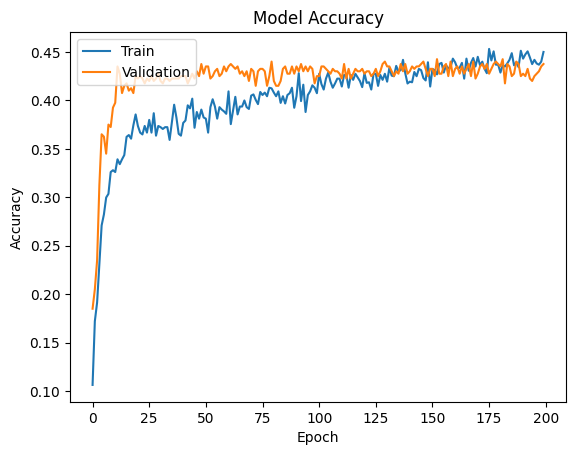

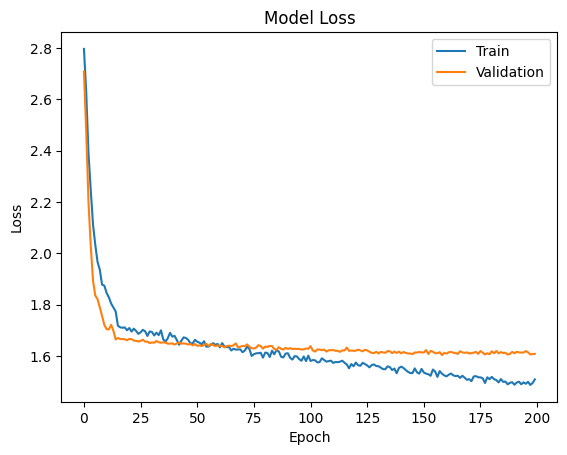

In [26]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and stored the history in a variable named 'history'

# Plotting the training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Evaluate the model

In [27]:

_, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

13/13 [==============================] - 0s 6ms/step - loss: 1.6078 - accuracy: 0.4375
Test accuracy: 0.4375


In [28]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the supported ops to TFLITE_BUILTINS and SELECT_TF_OPS
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
interpreter.pre

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get the input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare the input data
for x in X_test:
    X_test1 = np.expand_dims(x, axis=0)  # Add a batch dimension if needed
    X_test1 = X_test1.astype(np.float32)  # Convert to FLOAT32

    # Set the input tensor
    input_tensor_index = input_details[0]['index']
    interpreter.set_tensor(input_tensor_index, X_test1)

    # Run the inference
    interpreter.invoke()

    # Get the output tensor
    output_tensor_index = output_details[0]['index']
    output = interpreter.get_tensor(output_tensor_index)

    # Perform post-processing if needed
    # predictions = np.argmax(output, axis=1)  # Get the predicted classes

    # Print the predictions
    print(encoder.inverse_transform(output))


[['Sniffing']]
[['Standing']]
[['Drinking']]
[['Tugging']]
[['Standing']]
[['Standing']]
[['Standing']]
[['Bowing']]
[['Drinking']]
[['Galloping']]
[['Walking']]
[['Bowing']]
[['Jumping']]
[['Trotting']]
[['Standing']]
[['Sniffing']]
[['Eating']]
[['Shaking']]
[['Standing']]
[['Bowing']]
[['Drinking']]
[['Standing']]
[['Standing']]
[['Bowing']]
[['Pacing']]
[['Walking']]
[['Eating']]
[['Eating']]
[['Drinking']]
[['Walking']]
[['Walking']]
[['Pacing']]
[['Trotting']]
[['Standing']]
[['Standing']]
[['Standing']]
[['Galloping']]
[['Eating']]
[['Trotting']]
[['Trotting']]
[['Galloping']]
[['Walking']]
[['Sitting']]
[['Walking']]
[['Standing']]
[['Sniffing']]
[['Standing']]
[['Trotting']]
[['Trotting']]
[['Sitting']]
[['Sniffing']]
[['Sniffing']]
[['Galloping']]
[['Shaking']]
[['Standing']]
[['Trotting']]
[['Standing']]
[['Sniffing']]
[['Jumping']]
[['Tugging']]
[['Bowing']]
[['Galloping']]
[['Standing']]
[['Sniffing']]
[['Standing']]
[['Drinking']]
[['Standing']]
[['Walking']]
[['Shaking']

In [ ]:
encoder.inverse_transform(output)

array([['Standing']], dtype=object)

---